# Modelo C

por: Isabella Lozano Roncancio

# 1. Preparación del Ambiente

## Importaciones de librerias


In [63]:
import pandas as pd
#from ydata_profiling import ProfileReport

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
#from num2words import num2words
import matplotlib.pyplot as plt
import re, string, unicodedata
import matplotlib

%matplotlib inline
import numpy as np
import inflect
import joblib
import nltk


## Carga de Datos

In [64]:
df_original = pd.read_csv(r'datos\fake_news_spanish.csv', sep=';', encoding='utf-8')
df_original.head()

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018


In [65]:
train = df_original.copy()
train.head()

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018


# 2. Calidad de Datos

Se van a analizar 4 dimensiones distintas con respecto a la calidad de los datos (Completitud, Validez, Unicidad y Consistencia)

## Completitud

Luego de una breve inspección, se encuentra 16 valores nulos en la variable "Titulo" lo cual afecta la completitud en los datos.

In [66]:
train.isnull().sum()


ID              0
Label           0
Titulo         16
Descripcion     0
Fecha           0
dtype: int64

In [67]:
train.count()

ID             57063
Label          57063
Titulo         57047
Descripcion    57063
Fecha          57063
dtype: int64

In [68]:
train['Label'].value_counts()

Label
1    33158
0    23905
Name: count, dtype: int64

In [69]:
# strip all values in the column
train['Descripcion'] = train['Descripcion'].str.strip()
# count all values in the column where the value is an empty string
train['Descripcion'].isnull().sum()


0

## Validez

Hay un problema de codificación de los textos en el dataset (de la columna titulo y descripción), pues muchos caracteres que corresponden a vocales con tilde han sido reemplazados por caracteres no válidos.

In [70]:
def fix_encoding(text):
    replacements = {
        'Ã¡': 'á',
        'Ã©': 'é',
        'Ã­': 'í',
        'Ã³': 'ó',
        'Ãº': 'ú',
        'Ã±': 'ñ'
    }
    
    for wrong, correct in replacements.items():
        text = text.replace(wrong, correct)
    
    return text

train['Descripcion'] = train['Descripcion'].apply(fix_encoding)


convertir la columna Titulo de float a string para poder aplicar los cabios de fix_encoding

In [71]:
# Convertir la columna "Titulo" de float a string
train["Titulo"] = train["Titulo"].astype(str)

# Verificar el cambio de tipo de dato
train.dtypes["Titulo"]

dtype('O')

In [72]:
train['Titulo'] = train['Titulo'].apply(fix_encoding)


In [73]:
train.head(5)

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018


## Unicidad

En primera instancia, el dataset no tiene columnas que deban ser únicas siguiento algúna restricción de negocio. Bajo una inspección sencilla, parece haber filas totalmente duplicadas (445 datos completamente iguales).

In [74]:
train.duplicated().sum()

445

## Consistencia

La columna "ID" no es completamente única, lo que indica posibles inconsistencias

In [75]:
train["ID"].nunique() == len(train)

False

# Perfilamiento de los datos

Eliminacion de datos duplicados 

In [76]:
train.drop_duplicates(inplace=True)

In [77]:
train.count()

ID             56618
Label          56618
Titulo         56618
Descripcion    56618
Fecha          56618
dtype: int64

In [78]:
def mostrar_grafico1(palabras,stopwords=[]):
    comment_words = ''
    
    # iterate through the csv file
    for val in palabras:
        
        # typecaste each val to string
        val = str(val)
    
        # split the value
        tokens = val.split()
        
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        
        comment_words += " ".join(tokens)+" "
    
    
    wordcloud = WordCloud(width = 600, height = 600,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)
    
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad = 0)
    
    plt.show()

Acontinuación se va a ilustrar que palabras suelen repetirse y encontrarse en los Label's 0 y 1

---------- Words for class: 1 ----------


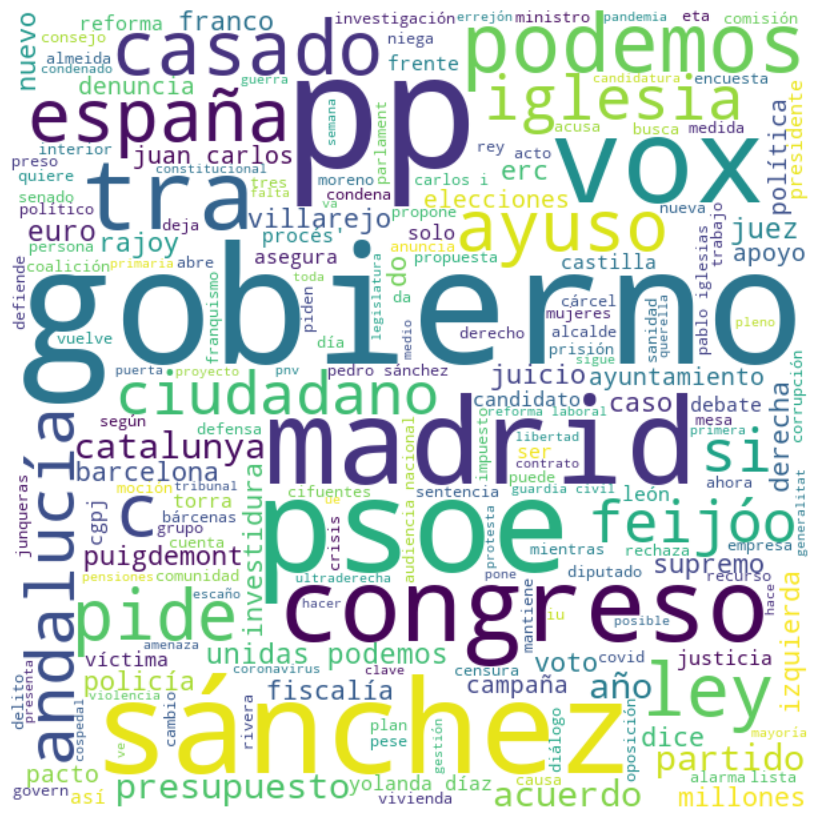

---------- Words for class: 0 ----------


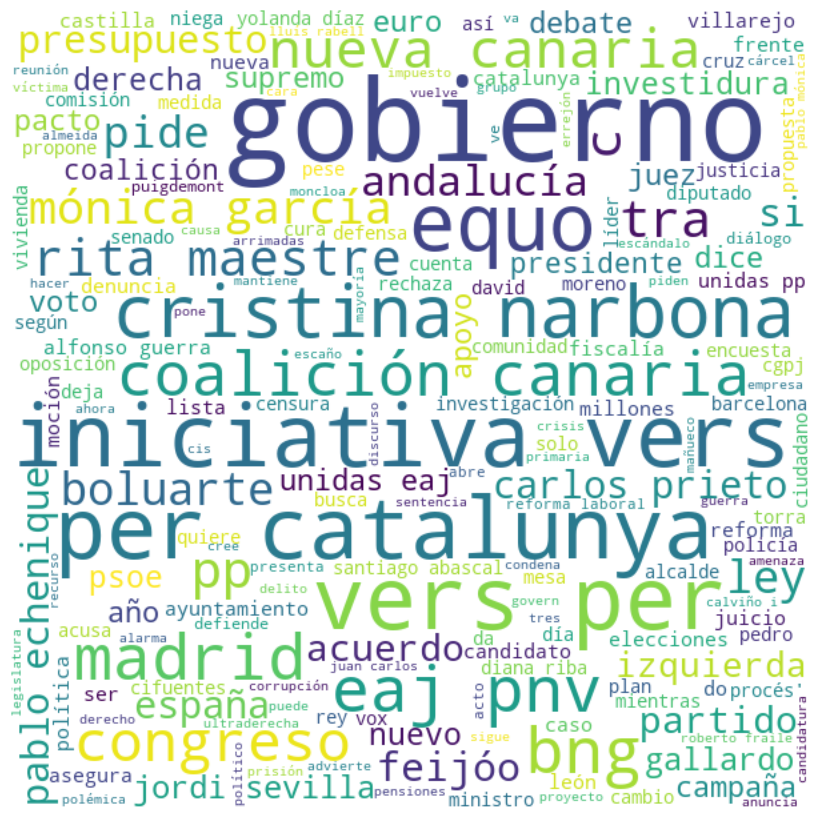

In [79]:
stop_words = set(nltk.corpus.stopwords.words('spanish'))

for i in train['Label'].unique():
    print(f'---------- Words for class: {i} ----------')
    mostrar_grafico1(train.loc[train['Label']==i,'Titulo'], stopwords=stop_words)

In [80]:
train

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018
...,...,...,...,...,...
57058,ID,1,El Defensor del Pueblo reclama a la Comunidad ...,El gobierno regional han indicado que la atenc...,08/06/2021
57059,ID,0,El EQUO plantea ceder la presidencia de la Com...,Si la higiene democrática nos lleva a esa exig...,08/09/2020
57060,ID,1,Alberto Garzón: 'Que los Borbones son unos lad...,El coordinador federal de IU asegura que la mo...,12/07/2018
57061,ID,1,Vox exige entrar en el Gobierno de Castilla y ...,Santiago Abascal: Vox tiene el derecho y el de...,13/02/2022


# Preparación de Datos


In [81]:
X_train, y_train = train['Titulo'], train['Label'] 
display(X_train)
y_train

0        'The Guardian' va con Sánchez: 'Europa necesit...
1        REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...
2        El 'Ahora o nunca' de Joan Fuster sobre el est...
3        Iglesias alienta a Yolanda Díaz, ERC y EH Bild...
4        Puigdemont: 'No sería ninguna tragedia una rep...
                               ...                        
57058    El Defensor del Pueblo reclama a la Comunidad ...
57059    El EQUO plantea ceder la presidencia de la Com...
57060    Alberto Garzón: 'Que los Borbones son unos lad...
57061    Vox exige entrar en el Gobierno de Castilla y ...
57062    Unas 300 personas protestan contra la visita d...
Name: Titulo, Length: 56618, dtype: object

0        1
1        0
2        1
3        1
4        0
        ..
57058    1
57059    0
57060    1
57061    1
57062    1
Name: Label, Length: 56618, dtype: int64

## Modificación de caracteres

Se pasan todos los caracteres a minuscula, se eliminan los textos de puntuación y asi mismo las stop words (que suelen ser palabras como articulos y conectores)

1. Cambiar a minusculas

In [82]:
def to_lower(words: list[str]):
    return [word.lower() for word in words]

2. Quitar puntuación

In [83]:
def remove_punctuation(words: list[str]):
    return [word for word in words if word.isalnum()]

3. Eliminar StopWords

In [84]:
def remove_stopwords(words: list[str]):
    stopwords = set(nltk.corpus.stopwords.words('spanish'))
    return [word for word in words if word not in stopwords]


In [85]:
def preprocessing(words):
    words = to_lower(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    return words

Ahora se va a hacer un procedimiento de Tokenizacion para desglozar las palabras

In [87]:
new_X_train = X_train.apply(word_tokenize)
new_X_train = new_X_train.apply(preprocessing) 
new_X_train.head()

LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\IsabellaLozano/nltk_data'
    - 'c:\\Users\\IsabellaLozano\\anaconda3\\nltk_data'
    - 'c:\\Users\\IsabellaLozano\\anaconda3\\share\\nltk_data'
    - 'c:\\Users\\IsabellaLozano\\anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\IsabellaLozano\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************
